# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**



---



# Exploración de Datos

#####Importing libraries and necessary packages to complete the project.

In [2]:
%%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import itertools
from statistics import mean

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

import warnings
from mpl_toolkits.mplot3d import Axes3D
import gc #garbage collector

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('spanish_grammars')
nltk.download('averaged_perceptron_tagger')

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
stopwords_nltk = set(stopwords.words('spanish'))
stopwords_nltk.remove('no') #It could be useful to analyze and predict negative reviews

import re
import spacy
from wordcloud import WordCloud

In [3]:
%%capture
#Install Spanish Language Package for Spacy
!python -m spacy download es_core_news_md

In [4]:
#Import Spanish Language Package for Spacy
import es_core_news_md
nlp = es_core_news_md.load()

from spacy.lang.es.stop_words import STOP_WORDS
stopwords_spacy = list(STOP_WORDS)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Link to Google Drive to get the data: https://drive.google.com/drive/folders/1ZtFevngkUO2k2RmBQswdgBhRCreZN2H7?usp=sharing

In [6]:
### Uploading the Dataset ###
data = pd.read_json('/content/gdrive/MyDrive/Colab Notebooks/Acamica/Sprint 3/Entregable/Data/dataset_es_train.json', lines=True)
print("- Total of records for training dataset:", data.shape[0])
data_es_test = pd.read_json('/content/gdrive/MyDrive/Colab Notebooks/Acamica/Sprint 3/Entregable/Data/dataset_es_test.json', lines=True)
print("- Total of records for testing dataset:", data_es_test.shape[0])
data_es_dev = pd.read_json('/content/gdrive/MyDrive/Colab Notebooks/Acamica/Sprint 3/Entregable/Data/dataset_es_dev.json', lines=True)
print("- Total of records for development dataset:", data_es_dev.shape[0])

- Total of records for training dataset: 200000
- Total of records for testing dataset: 5000
- Total of records for development dataset: 5000


###**a. Explora la fuente de datos. ¿Qué representa el dataset? ¿Hay información sobre las columnas?**


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         200000 non-null  object
 1   product_id        200000 non-null  object
 2   reviewer_id       200000 non-null  object
 3   stars             200000 non-null  int64 
 4   review_body       200000 non-null  object
 5   review_title      200000 non-null  object
 6   language          200000 non-null  object
 7   product_category  200000 non-null  object
dtypes: int64(1), object(7)
memory usage: 12.2+ MB


In [ ]:
### Print the columns names ###
data.columns

Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')

In [ ]:
data.dtypes

review_id           object
product_id          object
reviewer_id         object
stars                int64
review_body         object
review_title        object
language            object
product_category    object
dtype: object

In [ ]:
#Quantity of unique reviews  ## should be the total of rows
print("The total of unique reviews is", len(data['review_id'].unique()))

The total of unique reviews is 200000


In [ ]:
#Quantity of unique users
unique_users = len(data['reviewer_id'].unique())
print("The total of unique users is", unique_users, "which is the", unique_users*100//data.shape[0], "% of the total of reviews.")

The total of unique users is 179076 which is the 89 % of the total of reviews.


In [ ]:
#Quantity of unique products
unique_prod = len(data['product_id'].unique())
print("The total of unique products that received at least one review is", unique_prod, "which is the", unique_prod*100//data.shape[0], "% of the total of reviews.")

The total of unique products that received at least one review is 150938 which is the 75 % of the total of reviews.


###**b. Realiza un análisis exploratorio que incluya:**



*   Explora el head y tail del dataset.




In [ ]:
### Print the first 5 instances ###
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [ ]:
### Print the last 5 instances ###
data.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
199995,es_0715276,product_es_0317036,reviewer_es_0643604,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,es,electronics
199996,es_0085190,product_es_0622919,reviewer_es_0466173,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,es,electronics
199997,es_0484496,product_es_0358101,reviewer_es_0330744,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,es,apparel
199998,es_0930141,product_es_0788855,reviewer_es_0694290,5,Perfecto para el cumple de mi hijo,Recomendado,es,toy
199999,es_0859809,product_es_0378794,reviewer_es_0141717,5,"Súper bien! Las brochas son buenas, no sé meno...",Preciosas,es,home




*   Calcula el tamaño.



In [ ]:
### Print the shape (rows - columns) ###
data.shape

(200000, 8)



*   Calcular los principales estadísticos de las columnas: media, desviación estándar, etc.



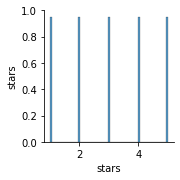

In [ ]:
sns.pairplot(data)

In [ ]:
data.describe()

,stars
count,200000.000000
mean,3.000000
std,1.414217
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000




*   Calcula los nulls



In [ ]:
### Print the missing values by column ###
missing_values_count = data.isnull().sum()
missing_values_count

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [ ]:
### Print the count of rows by column ###
data.count()

review_id           200000
product_id          200000
reviewer_id         200000
stars               200000
review_body         200000
review_title        200000
language            200000
product_category    200000
dtype: int64



*   Si consideras que agrega valor informativo, agrega algún gráfico



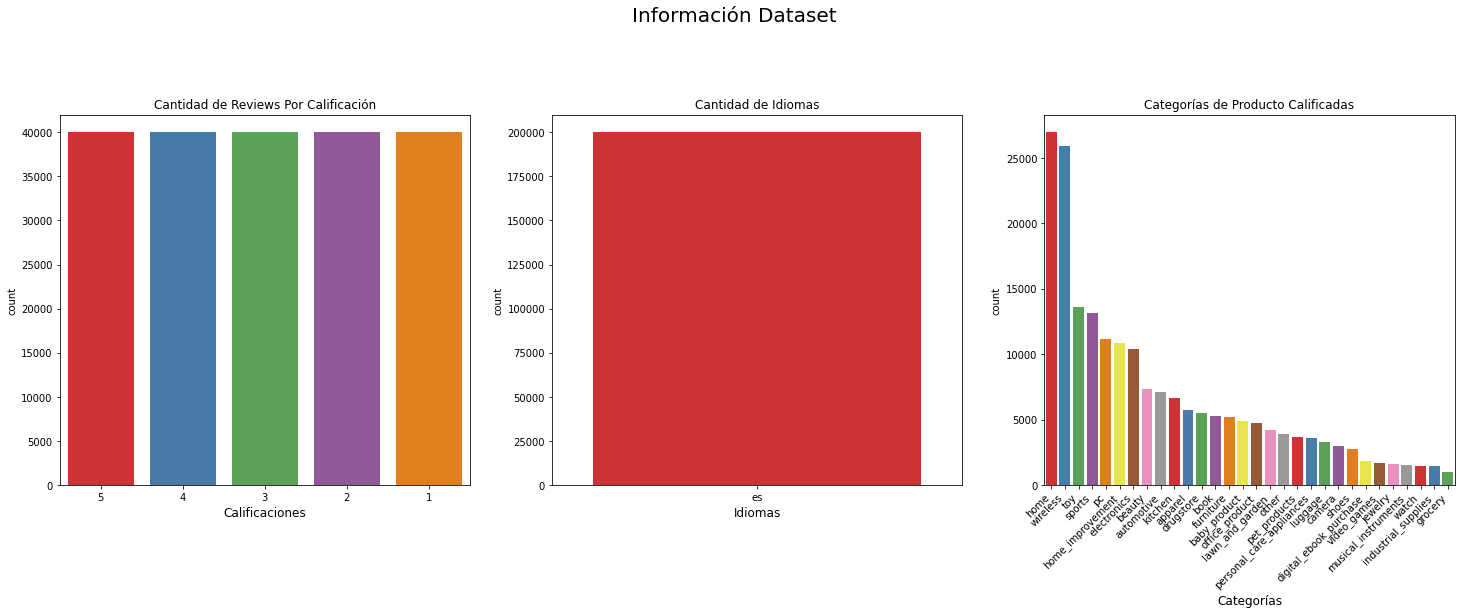

In [ ]:
warnings.filterwarnings('ignore')

plt.figure(figsize = (25,15))
plt.suptitle("Información Dataset", fontsize=20)

plt.subplot(2,3,1)
chart1 = sns.countplot(x = 'stars', data = data, order = data['stars'].value_counts().index, palette='Set1')
#chart1.set_xticklabels(chart.get_xticklabels(), horizontalalignment='right')
plt.xlabel("Calificaciones", fontsize=12)
plt.title('Cantidad de Reviews Por Calificación')

plt.subplot(2,3,2)
chart2 = sns.countplot(x = 'language', data = data, order = data['language'].value_counts().index, palette='Set1')
#chart2.set_xticklabels(chart.get_xticklabels(), horizontalalignment='right')
plt.xlabel("Idiomas", fontsize=12)
plt.title('Cantidad de Idiomas')

plt.subplot(2,3,3)
chart3 = sns.countplot(x = 'product_category', data = data, order = data['product_category'].value_counts().index, palette='Set1')
chart3.set_xticklabels(chart3.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel("Categorías", fontsize=12)
plt.title('Categorías de Producto Calificadas')

### Show the chart ###
plt.show()

### **c. Responde: ¿es necesario hacer alguna transformación de datos? ¿Hay nulls o columnas que no aportan información? Justifica.**

**English:**
It is important to debug the data to use the relevant data for training only. For this case I think I have to use the columns *stars, review_body and  review_title*. Using these columns I am going to do the Data analysis to interpret and iterate the data, and getting the prediction for each score (stars).

**Español:**
Es importante depurar la data para usar solamente los datos que son relevantes para el entrenamiento; en este caso considero que se deben usar las columnas: *stars, review_body,  review_title*. De esa manera se podrá hacer el análisis respectivo de la data, para interpretar los comentarios y poder predecir la calificación.

###**d. Elige cuáles de las siguientes transformaciones de datos son apropiadas para el dataset:**



*   Detección y eliminación de Outliers



**English:**
I consider it is not necessary to detect and delete outliers, considering we are going to work on NLP, so it is not probable we will find outliers. However, we keep in mind that some outliers could appear in terms on frequency of words or some repetitive words that are not important in the NLP. For those cases, the stopwords list could be useful.

**Español:**
Creo poco probable que encontremos outliers en el análisis, considerando que estamos trabajando con palabras en el procesamiento de lenguaje natural. Sin embargo, al analizar la frecuencia de palabras o al revisar las palabras que se repiten y que son poco útiles en la sintaxis del texto, podrían aparecer casos que podrían tratarse como "outliers". Para ello, el listado de palabras a eliminar (stopwords) nos podría ayudar a eliminar esos "outliers".



*   Encoding




**English:**
I think it could be useful to transform y values as target for the model. In this case, the excercise requires to process the score from 1 to 5, but it could be interesting to analyze the score as a binary result (positive - negative).

**Español:**
Encoding podría usarse para transformar el score de los productos (que va en una escala de 1 a 5) a un resultado binario, donde unos comentarios sean positivos, y otros negativos.



*   Imputación de valores faltantes



**English:**
I don't think it could be used for this excercise, considering we are going to work on NLP and words.

**Español:**
No creo que sea necesario imputar valores faltantes, entendiendo que vamos a trabajar con palabras para NLP.



*   Escalado de Datos




**English:**
It depends on the size of the datasets, and the result of processing them.

**Español:**
Dependerá del tamaño de los datasets y del resultado de su procesamiento.



*   Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA)




**English:**
Joined to the previous question!

**Español:**
Está atado al punto anterior, dependerá del resultado de procesar los datasets, y de lo conveniente que sea hacer un PCA.

###**e. Realiza al menos 2 gráficos que aporten información para el entendimiento e interpretación de los datos.**

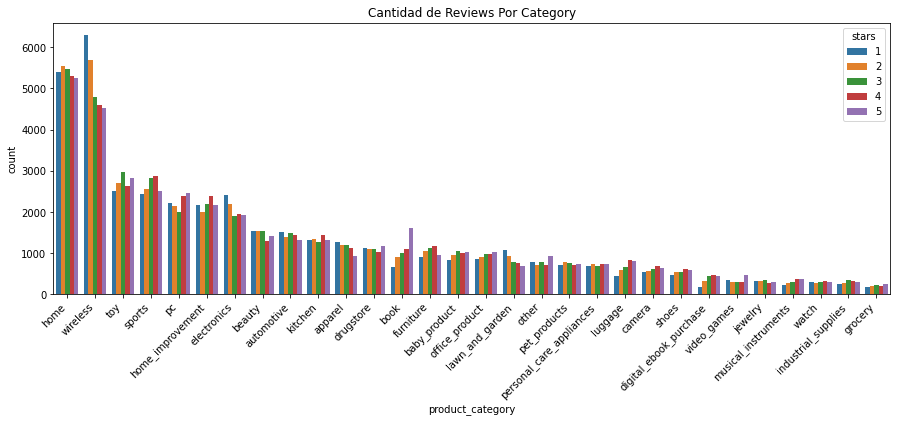

In [ ]:
# Chart to idenitfy which category has more reviews and the breakout by score
plt.figure(figsize=(15,5))
grafico = sns.countplot(x=data['product_category'],data=data, order = data['product_category'].value_counts().index, hue='stars')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45, ha="right")
plt.title('Cantidad de Reviews Por Category')
plt.show()

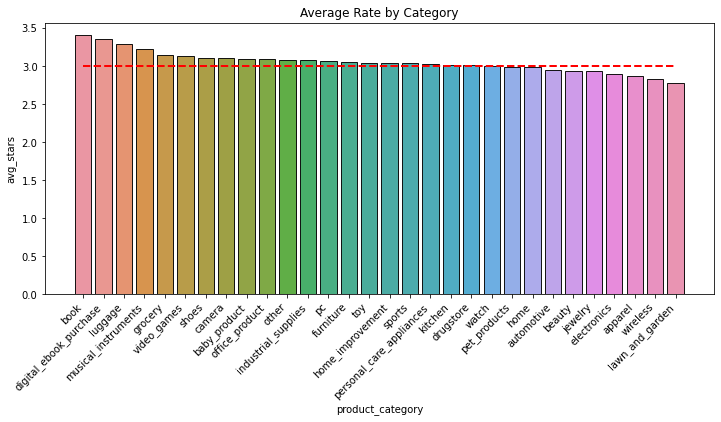

In [ ]:
data_grouped = data.stars.groupby([data['product_category']]).mean().reset_index(name='avg_stars')
data_grouped['rev_count'] = data.stars.groupby([data['product_category']]).count().astype(int).reset_index(name='rev_count').rev_count

# Average rate by Category
data_grouped.sort_values(['avg_stars','rev_count'],ascending=False,inplace=True)
cte = np.ones(data_grouped.shape[0])*3 
plt.figure(figsize=(12,5))
chart4 = sns.barplot(x=data_grouped.product_category, y=data_grouped.avg_stars, linewidth=0.9,edgecolor=(0,0,0))
plt.plot(cte, ls = '--', lw = 2, c='r',label = 'Average')
chart4.set_xticklabels(chart4.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Average Rate by Category", fontsize=12)
plt.show()


# Modelo de Machine Learning

###**f. Desarrolla tu modelo.**

In [7]:
#Start doing the split of the database to work only with the related data for the ml model
warnings.filterwarnings('ignore')

#Generate copy of the data
data_copy = pd.DataFrame(data.copy())
columns_2_use = ['stars', 'review_body', 'review_title']

print('Data Total is',data_copy.shape)

#Generate data for ml model (Total of database with the columns to train the model)
data_ml = data_copy[columns_2_use]
print('Data for model is',data_ml.shape)

#Split the data by star rates, we will use these bases for the new pipeline
data1 = data_copy[data_copy['stars'] == 1]
data1 = data1[columns_2_use]
print('Data with star rate 1 is',data1.shape)

data2 = data_copy[data_copy['stars'] == 2]
data2 = data2[columns_2_use]
print('Data with star rate 2 is',data2.shape)

data3 = data_copy[data_copy['stars'] == 3]
data3 = data3[columns_2_use]
print('Data with star rate 3 is',data3.shape)

data4 = data_copy[data_copy['stars'] == 4]
data4 = data4[columns_2_use]
print('Data with star rate 4 is',data4.shape)

data5 = data_copy[data_copy['stars'] == 5]
data5 = data5[columns_2_use]
print('Data with star rate 5 is',data5.shape)

Data Total is (200000, 8)
Data for model is (200000, 3)
Data with star rate 1 is (40000, 3)
Data with star rate 2 is (40000, 3)
Data with star rate 3 is (40000, 3)
Data with star rate 4 is (40000, 3)
Data with star rate 5 is (40000, 3)


In [ ]:
data_ml.head()

,stars,review_body,review_title
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.
4,1,Llega tarde y co la talla equivocada,Devuelto


In [ ]:
todas_palabras_review = []
for i in range(data_ml.shape[0]):
  palabras_body = data_ml.iloc[i].review_body
  palabras_body = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(palabras_body)
  palabras_body = [word for word in palabras_body if word not in stopwords_nltk]
  
  todas_palabras_review.append(palabras_body)

todas_palabras_review = list(itertools.chain(*todas_palabras_review))

In [ ]:
print(len(todas_palabras_review))

3117315


In [ ]:
freq_todas_palabras_review = nltk.FreqDist(todas_palabras_review)
df_freq_todas_palabras_review = pd.DataFrame(list(freq_todas_palabras_review.items()), columns=["word","Frequency"])
df_freq_todas_palabras_review.sort_values("Frequency", ascending=False, inplace=True)
df_freq_todas_palabras_review.reset_index(drop=True, inplace=True)
df_freq_todas_palabras_review[:10]

,word,Frequency
0,no,118502
1,bien,50061
2,No,34275
3,calidad,29647
4,El,27528
5,La,22967
6,producto,22770
7,precio,22280
8,si,20988
9,Es,19016


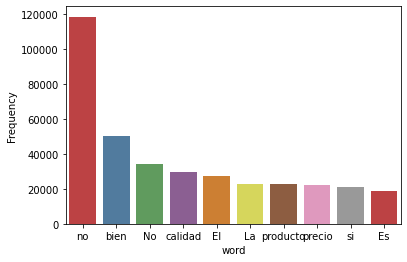

In [ ]:
freq_word = df_freq_todas_palabras_review[:10]

ax = sns.barplot(data=freq_word, x="word", y="Frequency", palette='Set1', saturation=0.6,)

In [11]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

***The following code takes at least 20min to be executed.***

In [12]:
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

# We got the stopwords again
stopwords_nltk = set(stopwords.words('spanish'))
stopwords_nltk.remove('no') #It could be useful to analyze and predict negative reviews


# We the reviews and doing normalization, stemming and lematizer for each one
text_list=[]
for texto in data_ml.review_body:
    # Replacing numbers by letters characters 
    texto=re.sub("[^a-zA-Z]"," ",str(texto))
    # Lower case for all words
    texto=texto.lower()
    # Tokenizer the words for each review
    texto=nltk.word_tokenize(texto)
    
    ## Applying the stemmer to get the root of each word
    texto=[stemmer.stem(palabra) for palabra in texto]

    # Doing lemmatizer 
    texto = [wordnet_lemmatizer.lemmatize(palabra, get_wordnet_pos(palabra)) for palabra in texto]

    # Deleting 3-letter words
    # texto = [palabra for palabra in texto if (texto =="no" or len(palabra)>2)]
    
    # Discarding Stopwords
    texto = [palabra for palabra in texto if not palabra in stopwords_nltk]
    
    # Joining the reviews
    texto=" ".join(texto)
    
    # Getting the list of all reviews
    text_list.append(texto)
    

In [13]:
data_ml["body_lemm"] = text_list
data_ml.tail()

,stars,review_body,review_title,body_lemm
199995,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,mando funciona perfectament cumpl toda funcion...
199996,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,compr bater cierta reticencia result f cil ins...
199997,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,buena calidad satisfecha compra
199998,5,Perfecto para el cumple de mi hijo,Recomendado,perfecto cumpl hijo
199999,5,"Súper bien! Las brochas son buenas, no sé meno...",Preciosas,s per bien brocha buena no s meno ca do pelito...


In [ ]:
data_ml.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Acamica/Sprint 3/Entregable/Data/data_ml.csv', index=False, header=True)

In [ ]:
#Import The ML data
data_ml = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Acamica/Sprint 3/Entregable/Data/data_ml.csv')
data_ml.head()

,stars,review_body,review_title,body_lemm
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,bueno ka pantalla meno mese no recibido respue...
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,horribl no tuvimo comprar porqu nosotro sabemo...
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,obligan comprar do unidad llega solo no forma ...
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,no entro descalificar vendedor solo puedo deci...
4,1,Llega tarde y co la talla equivocada,Devuelto,llega tard co talla equivocada


In [ ]:
#Function to create wordcloud
def ver_wordcloud(palabras):
    text = ' '.join(palabras)
    wordcloud = WordCloud(background_color='white',width=900,height=450).generate(text.strip())
    plt.figure(figsize = (15,8), facecolor = None)
    plt.imshow(wordcloud, interpolation='kaiser')
    plt.axis("off")
    plt.show()

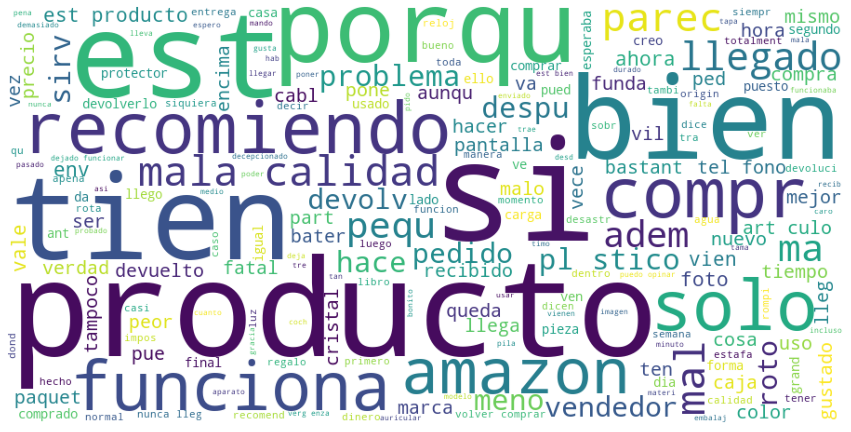

In [ ]:
data_star_1 = data_ml[data_ml['stars']==1]
ver_wordcloud(data_star_1["body_lemm"])

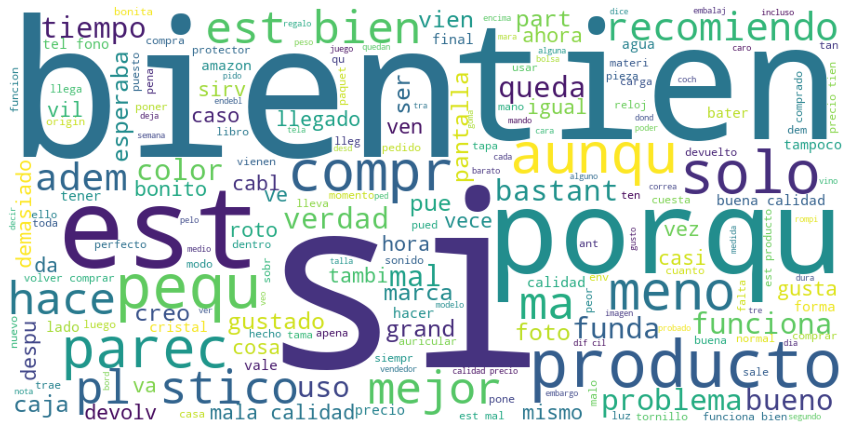

In [ ]:
data_star_2 = data_ml[data_ml['stars']==2]
ver_wordcloud(data_star_2["body_lemm"])

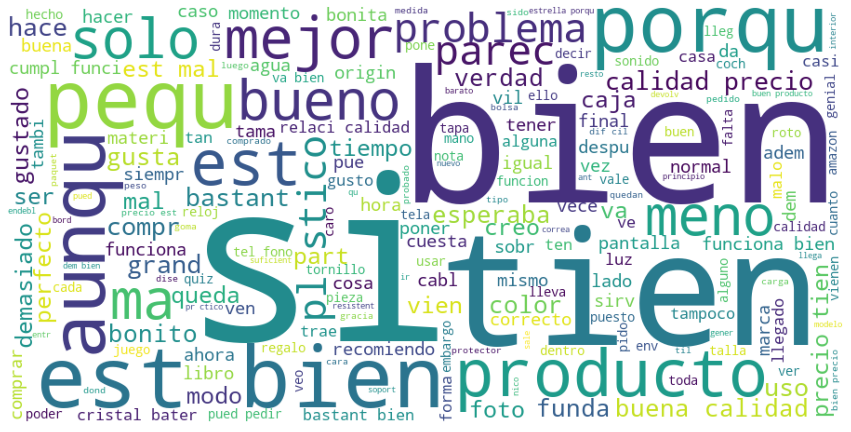

In [ ]:
data_star_3 = data_ml[data_ml['stars']==3]
ver_wordcloud(data_star_3["body_lemm"])

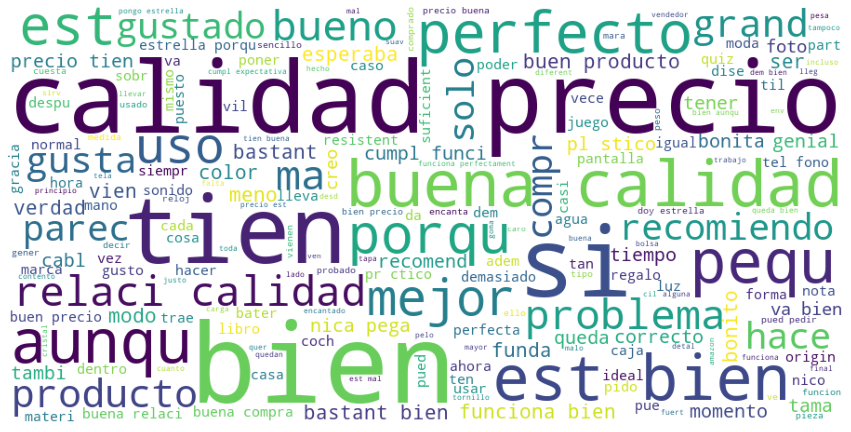

In [ ]:
data_star_4 = data_ml[data_ml['stars']==4]
ver_wordcloud(data_star_4["body_lemm"])

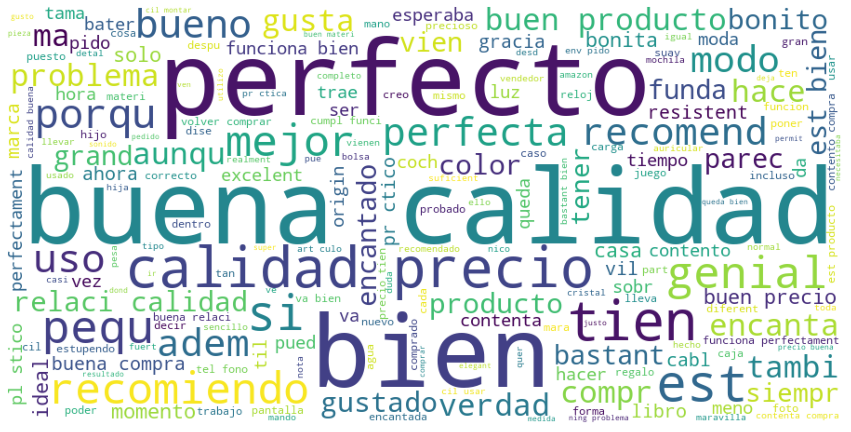

In [ ]:
data_star_5 = data_ml[data_ml['stars']==5]
ver_wordcloud(data_star_5["body_lemm"])

In [14]:
#Vectorizar los reviews lemmatizados

# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import train_test_split

# Usaremos solo las 2000 palabras con mas frecuencia en todo el corpus para generar los vectores, para optimizar la memoria
max_features=2000
vectorizer = CountVectorizer(max_features=max_features)


#Use it when import data_ml from Drive
#reviews = list(data_ml.body_lemm.values.astype('U'))

#Use it when run the process
reviews = list(data_ml.body_lemm.values)
stars = data_ml.stars.values

X = vectorizer.fit_transform(reviews)
# # print(vectorizer.get_feature_names()[0:50])

x = X.toarray()
y = stars

#Creamos los conjuntos de train y test para el entrenamiento del modelo
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [ ]:
#método para generar la matriz de confusión
def confusion(ytest,y_pred):
    names=["1","2","3","4","5"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

acc Gaussian:  0.378925


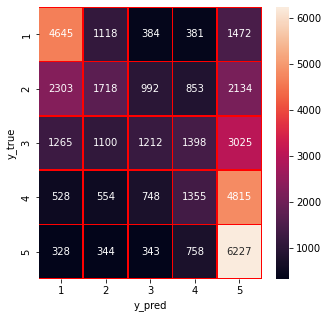

In [ ]:
#from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
#imprime la exactitud o accuracy
print("acc Gaussian: ", nb.score(xtest,ytest))
#confusion matrix
y_pred = nb.predict(xtest)
confusion(ytest,y_pred)

acc LinearSVC:  0.48415


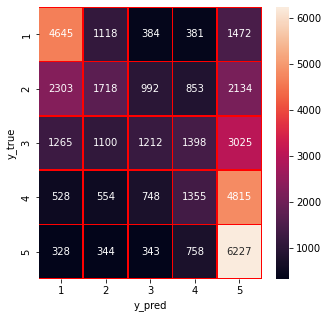

In [ ]:
#from sklearn.svm import LinearSVC
svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)
print("acc LinearSVC: ", svc.score(xtest,ytest))
#confusion matrix
y_pred = nb.predict(xtest)
confusion(ytest,y_pred)

acc RandomForest:  0.45585


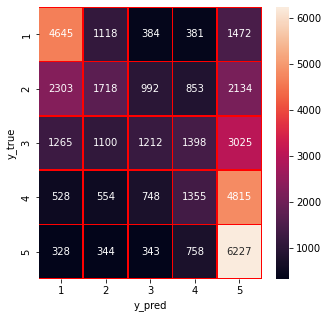

In [ ]:
# ***The following code takes at least 15min to be executed.***
rfmodel = RandomForestClassifier(random_state=42)
rfmodel.fit(xtrain,ytrain)
print("acc RandomForest: ",rfmodel.score(xtest,ytest))
#confusion matrix
y_pred = nb.predict(xtest)
confusion(ytest,y_pred)

###**g. Optimiza los hiper parámetros de tu modelo.**

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
# Random Search Grid
param_dist = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [100, 150, 250, 350]
              }

rfmodel = RandomForestClassifier(random_state=42)

mejor_modelo = RandomizedSearchCV(rfmodel, param_dist, n_iter=100, random_state=42, cv=5)
mejor_modelo.fit(xtrain, ytrain)

print("Mejores parametros: "+str(mejor_modelo.best_params_))
print("Mejor Score: "+str(mejor_modelo.best_score_)+'\n')

In [ ]:
#Reentrenemos el modelo randomforest con los nuevos parámetros propuestos por el proceso de optimización
rfmodel = RandomForestClassifier(n_estimators = 350, min_samples_split = 2, min_samples_leaf = 2, max_depth = 50, random_state=42)
rfmodel.fit(xtrain,ytrain)
print("acc: ",rfmodel.score(xtest,ytest))

###**h. Elige un modelo benchmark para comparar los resultados de tu modelo.**

In [ ]:
#Vectorizar los reviews lemmatizados

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split

# Usaremos solo las 2000 palabras con mas frecuencia en todo el corpus para generar los vectores, para optimizar la memoria
max_features=2000
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)


#Use it when import data_ml from Drive
#reviews = list(data_ml.body_lemm.values.astype('U'))

#Use it when run the process
reviews = list(data_ml.body_lemm.values)

stars = data_ml.stars.values

X = tfidf_vectorizer.fit_transform(reviews)
# # print(vectorizer.get_feature_names()[0:50])

x = X.toarray()
y = stars

#Creamos los conjuntos de train y test para el entrenamiento del modelo
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

acc Gaussian:  0.3996


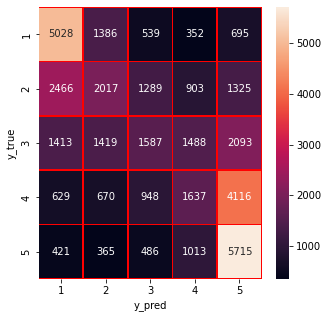

In [ ]:
#from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
#imprime la exactitud o accuracy
print("acc Gaussian: ", nb.score(xtest,ytest))
#confusion matrix
y_pred = nb.predict(xtest)
tfidVect_gau = confusion(ytest,y_pred)
tfidVect_gau

acc LinearSVC:  0.485675


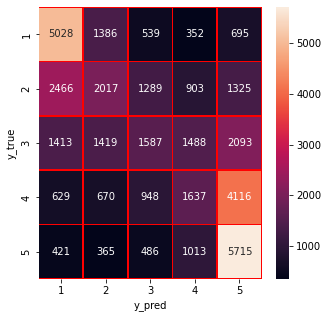

In [ ]:
#from sklearn.svm import LinearSVC
svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)
print("acc LinearSVC: ", svc.score(xtest,ytest))
#confusion matrix
y_pred = nb.predict(xtest)
tfidVect_svc = confusion(ytest,y_pred)
tfidVect_svc

acc RandomForest:  0.46425


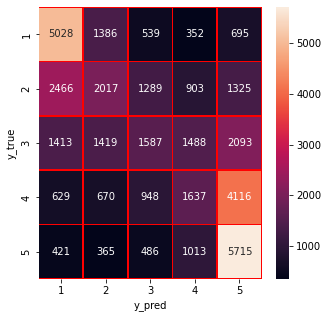

In [ ]:
rfmodel = RandomForestClassifier(random_state=42)
rfmodel.fit(xtrain,ytrain)
print("acc RandomForest: ",rfmodel.score(xtest,ytest))
#confusion matrix
y_pred = nb.predict(xtest)
tfidVect_rfst = confusion(ytest,y_pred)
tfidVect_rfst

###**i. Responde: ¿qué información está usando el modelo para predecir?**

Actualmente, el modelo está utilizando tanto los reviews como la frecuencia de palabras en cada review, para determinar cuál es la relación existente entre las palabras usadas en cada review y la calificación que se otorga. De esa manera, podrá asociar mediante los modelos de ML aplicados, dicha relación entre palabras y calificación, y sobre eso hará la predicción del review con base en los comentarios recibidos.

# Investigación

###**j. Plantea nuevas preguntas en base al trabajo que hiciste y en las que se pueda ahondar.**

**English:**
¿Is it NLTK the best option to use for this model?

**Español:**
Es la libreria NLTK la mejor herramienta para este modelo?

###**k. Plantea un flujo de trabajo que responda alguna o algunas de esas preguntas.**

Inicialmente, vamos a importar e instalar un modelo de NLP que pueda ser contrastado frente a los resultados obtenidos hasta el momento. Luego, haremos un EDA para revisar que, tanto la tokenization como el lemmatization sean similares al primer ejercicio. Finalmente, procederemos a ejectuar los mismos modelos de ML para comparar los resultados obtenidos.

# Requerimientos Adicionales

###**l. Implementa el flujo de trabajo planteado**

In [ ]:
#Import Spanish Language Package for Spacy
import es_core_news_md
nlp = es_core_news_md.load()

from spacy.lang.es.stop_words import STOP_WORDS
stopwords_spacy = list(STOP_WORDS)

# Quitamos de las stopwords palabras como 'no', 'bueno', 'buena' que nos pueden ser últiles para predecir
stopwords_spacy.remove('no') # En los comentarios negativos es muy repetida
stopwords_spacy.remove('bueno')
stopwords_spacy.remove('buena')
stopwords_spacy.remove('bien')
stopwords_spacy.remove('buenos')
stopwords_spacy.remove('tarde')
stopwords_spacy.remove('temprano')
stopwords_spacy.remove('día')
stopwords_spacy.remove('días')
stopwords_spacy.remove('dia')
stopwords_spacy.remove('dias')
stopwords_spacy.remove('grandes')
stopwords_spacy.remove('general')

In [ ]:
#We retrieve the data by stars, done previously:
data1 #Data with star: 1
print('Data with star rate 1 is',data1.shape)
data2 #Data with star: 2
print('Data with star rate 2 is',data2.shape)
data3 #Data with star: 3
print('Data with star rate 3 is',data3.shape)
data4 #Data with star: 4
print('Data with star rate 4 is',data4.shape)
data5 #Data with star: 5
print('Data with star rate 5 is',data5.shape)

Data with star rate 1 is (40000, 3)
Data with star rate 2 is (40000, 3)
Data with star rate 3 is (40000, 3)
Data with star rate 4 is (40000, 3)
Data with star rate 5 is (40000, 3)


In [ ]:
data1.head()

,stars,review_body,review_title
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.
4,1,Llega tarde y co la talla equivocada,Devuelto


In [ ]:
#create the function to iterate each dataset
def word_list(dataframe):
    todas_reviews = []
    for i in range(dataframe.shape[0]):
      palabras_body = dataframe.iloc[i].review_body
      palabras_body = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(palabras_body)
      palabras_body = [word.lower() for word in palabras_body if word not in stopwords_spacy and (word=="no" or len(word)>2)]
      todas_reviews.append(palabras_body)
    todas_reviews = list(itertools.chain(*todas_reviews))
    return todas_reviews

#create the function to analyze the frequency of the words
def word_frequency(todas_reviews):
    freq_revs = nltk.FreqDist(todas_reviews)
    df_revs = pd.DataFrame(freq_revs.items(), columns = ['word', 'Frequency'])
    df_revs.sort_values(by=['Frequency'], inplace=True, ascending=False)
    df_revs.reset_index(drop = True, inplace=True) 
    df_revs[:10]
    return df_revs

In [ ]:
df_data1 = word_list(data1)
freq_word1 = word_frequency(df_data1)

df_data2 = word_list(data2)
freq_word2 = word_frequency(df_data2)

df_data3 = word_list(data3)
freq_word3 = word_frequency(df_data3)

df_data4 = word_list(data4)
freq_word4 = word_frequency(df_data4)

df_data5 = word_list(data5)
freq_word5 = word_frequency(df_data5)

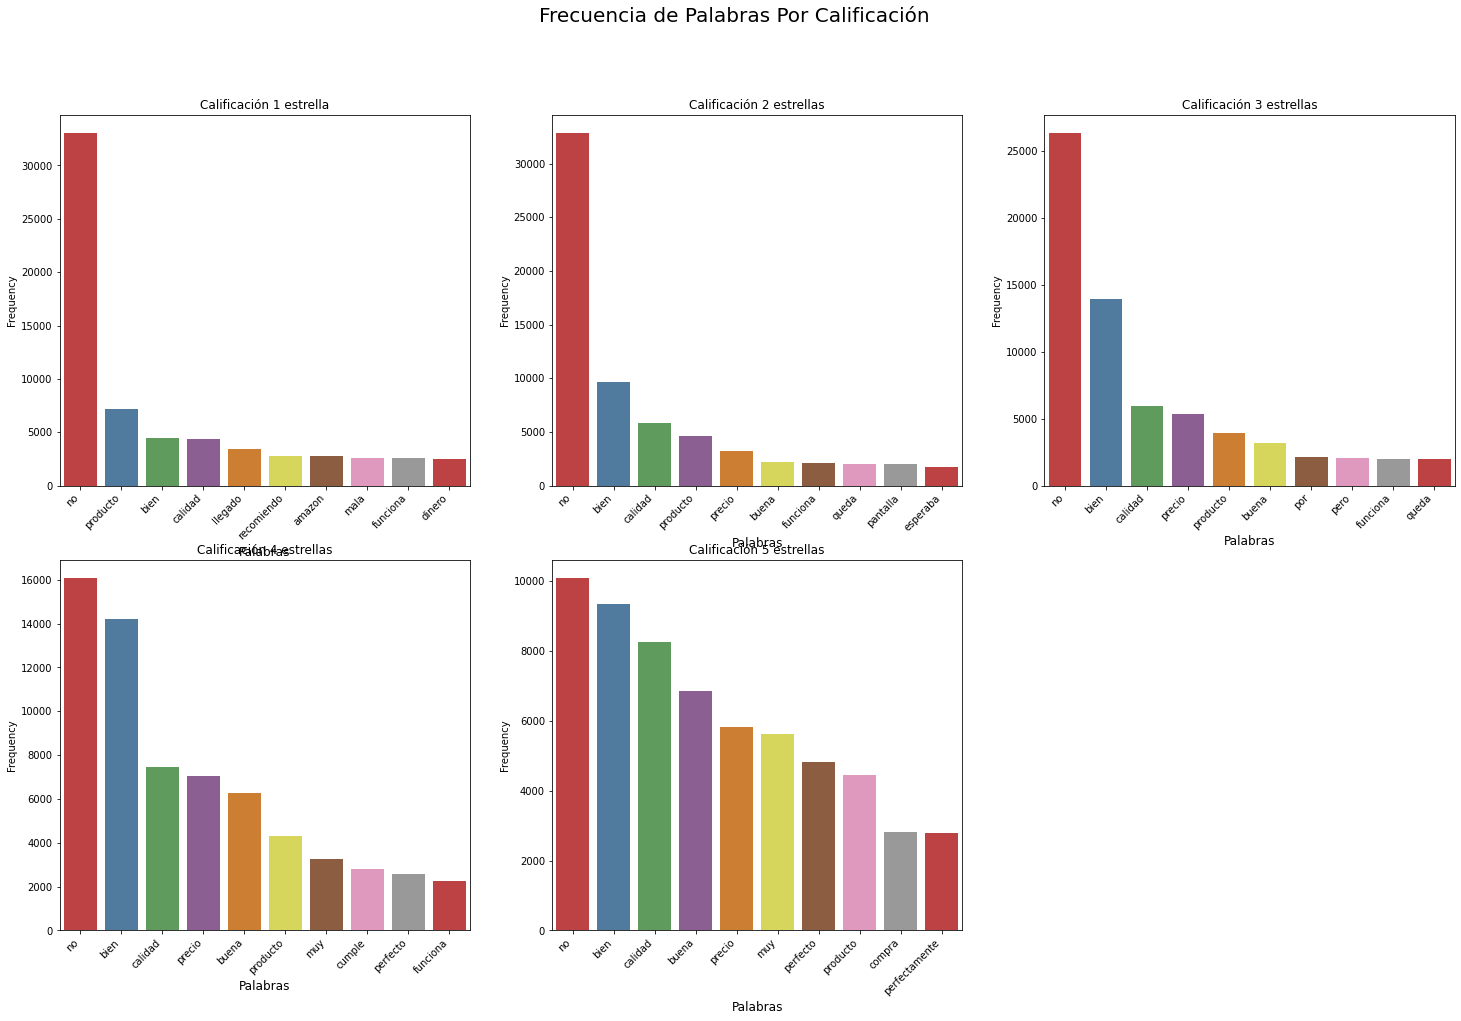

In [ ]:
warnings.filterwarnings('ignore')

plt.figure(figsize = (25,15))
plt.suptitle("Frecuencia de Palabras Por Calificación", fontsize=20)

plt.subplot(2,3,1)
chart1 = sns.barplot(data=freq_word1.iloc[:10], x="word", y="Frequency", palette='Set1', saturation=0.6,)
chart1.set_xticklabels(chart1.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel("Palabras", fontsize=12)
plt.title('Calificación 1 estrella')

plt.subplot(2,3,2)
chart2 = sns.barplot(data=freq_word2.iloc[:10], x="word", y="Frequency", palette='Set1', saturation=0.6,)
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel("Palabras", fontsize=12)
plt.title('Calificación 2 estrellas')

plt.subplot(2,3,3)
chart3 = sns.barplot(data=freq_word3.iloc[:10], x="word", y="Frequency", palette='Set1', saturation=0.6,)
chart3.set_xticklabels(chart3.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel("Palabras", fontsize=12)
plt.title('Calificación 3 estrellas')

plt.subplot(2,3,4)
chart4 = sns.barplot(data=freq_word4.iloc[:10], x="word", y="Frequency", palette='Set1', saturation=0.6,)
chart4.set_xticklabels(chart4.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel("Palabras", fontsize=12)
plt.title('Calificación 4 estrellas')

plt.subplot(2,3,5)
chart5 = sns.barplot(data=freq_word5.iloc[:10], x="word", y="Frequency", palette='Set1', saturation=0.6,)
chart5.set_xticklabels(chart5.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel("Palabras", fontsize=12)
plt.title('Calificación 5 estrellas')

### Show the chart ###
plt.show()

In [ ]:
def text_data_lemma(sentence):
    doc = nlp(sentence)
    
    clean_tokens = []
    for token in doc:
        if (token.pos_ and str(token) not in stopwords_spacy and (str(token)=="no" or len(token)>2)): 
            temp = token.lemma_.strip()
            clean_tokens.append(temp.lower())
    
    return clean_tokens

from nltk.stem.snowball import SpanishStemmer # Permite stemmizar palabras en español
stemmer = SpanishStemmer()

#Función para limpieza de datos con stemmer
def text_data_stem(sentence):
    doc = nlp(sentence)
    
    clean_tokens = []
    for token in doc:
        if (token.pos_ and str(token) not in stopwords_spacy and (token=="no" or len(token)>2)): 
            temp = stemmer.stem(token.text).strip()
            clean_tokens.append(temp.lower())
    
    return clean_tokens

The next code will spend at least 10min

In [ ]:
# Limpiamos todas las reviews con lemmatizer
reviews_lemma1 = []
for i in data1.index:
    rev = text_data_lemma(data1.review_title.iloc[i] + ' ' + data1.review_body.iloc[i])
    reviews_lemma1.append(" ".join(rev))
reviews_lemma1[:5]

['television nevir nada bueno pantalla mesar no recibir respuesta fabricante',
 'dinero tirar basura comprar horrible tener comprar inglés informático hora capaz instalarlo',
 'llegar unidad obligar comprar obligar comprar unidad llegar no formar reclamar autenticar estafar no compreis',
 'producto recibido entrar descalificar vendedor mesar esperar .... seguir producto tener contactar amazon reclamar reembolsar amazon cargar problema desembolsar dinero mesar devolver perdida total sin palabra ustedes decidir',
 'devuelto llega tardar tallar equivocar']

In [ ]:
data1["body_lemm"] = reviews_lemma1
data1.head()

,stars,review_body,review_title,body_lemm
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,television nevir nada bueno pantalla mesar no ...
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,dinero tirar basura comprar horrible tener com...
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,llegar unidad obligar comprar obligar comprar ...
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,producto recibido entrar descalificar vendedor...
4,1,Llega tarde y co la talla equivocada,Devuelto,devuelto llega tardar tallar equivocar


In [ ]:
# Limpiamos todas las reviews con lemmatizer
reviews_lemma = []
for i in data_ml.index:
    rev = text_data_lemma(data_ml.review_title.iloc[i] + ' ' + data_ml.review_body.iloc[i])
    reviews_lemma.append(" ".join(rev))
reviews_lemma[:5]

['television nevir nada bueno pantalla mesar no recibir respuesta fabricante',
 'dinero tirar basura comprar horrible tener comprar inglés informático hora capaz instalarlo',
 'llegar unidad obligar comprar obligar comprar unidad llegar no formar reclamar autenticar estafar no compreis',
 'producto recibido entrar descalificar vendedor mesar esperar .... seguir producto tener contactar amazon reclamar reembolsar amazon cargar problema desembolsar dinero mesar devolver perdida total sin palabra ustedes decidir',
 'devuelto llega tardar tallar equivocar']

In [ ]:
data_ml["body_lemm"] = reviews_lemma
data_ml.head()

,stars,review_body,review_title,body_lemm
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,television nevir nada bueno pantalla mesar no ...
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,dinero tirar basura comprar horrible tener com...
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,llegar unidad obligar comprar obligar comprar ...
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,producto recibido entrar descalificar vendedor...
4,1,Llega tarde y co la talla equivocada,Devuelto,devuelto llega tardar tallar equivocar


In [ ]:
#Vectorizar los reviews lemmatizados

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split

# Usaremos solo las 2000 palabras con mas frecuencia en todo el corpus para generar los vectores, para optimizar la memoria
max_features=2000
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)


#Use it when import data_ml from Drive
#reviews = list(data_ml.body_lemm.values.astype('U'))

#Use it when run the process
reviews = list(data_ml.body_lemm.values)

stars = data_ml.stars.values

X = tfidf_vectorizer.fit_transform(reviews)
# # print(vectorizer.get_feature_names()[0:50])

x = X.toarray()
y = stars

#Creamos los conjuntos de train y test para el entrenamiento del modelo
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

acc Gaussian:  0.407275


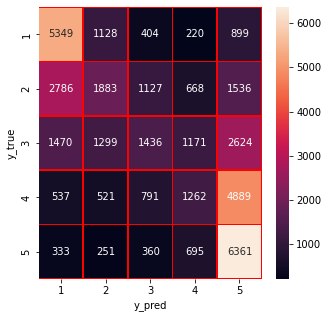

In [ ]:
#from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
#imprime la exactitud o accuracy
print("acc Gaussian: ", nb.score(xtest,ytest))
#confusion matrix
y_pred = nb.predict(xtest)
confusion(ytest,y_pred)

acc LinearSVC:  0.5125


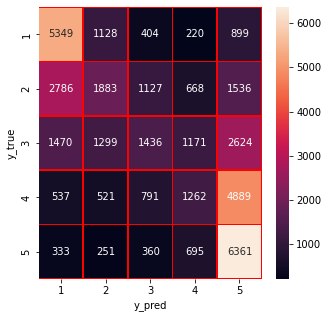

In [ ]:
#from sklearn.svm import LinearSVC
svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)
print("acc LinearSVC: ", svc.score(xtest,ytest))
#confusion matrix
y_pred = nb.predict(xtest)
confusion(ytest,y_pred)

acc RandomForest:  0.4886


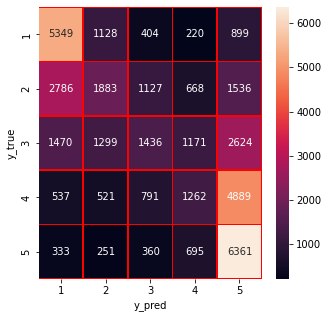

In [ ]:
rfmodel = RandomForestClassifier(random_state=42)
rfmodel.fit(xtrain,ytrain)
print("acc RandomForest: ",rfmodel.score(xtest,ytest))
#confusion matrix
y_pred = nb.predict(xtest)
confusion(ytest,y_pred)